In [2]:
import os
import grp
import math
import anndata
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# These next parts are for removing some noise from the output so as to not confuse the information.
sc.settings.verbosity = 0
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=anndata.ImplicitModificationWarning)
sc.settings.set_figure_params(dpi=80)

In [3]:
user_name = os.environ.get('USER')
user_group = 'staff' if 700181 in os.getgroups() else "student" # Magic to get the correct output paths setup.

class_directory = Path('/', 'courses', 'BINF6430.202510')
student_directory = Path(class_directory, user_group, user_name)
results = Path(student_directory, "write", "pbmc43k.h5ad")


data_sample_list = ['49-AdipoB', '49-DM', '916-AdipoB', '916-DM']

### Data
data_1 = Path(class_directory, 'data', 'LiawData', '10x_FRP_12-16-22',
            'analysis', 'MMC-1', 'outs', 'per_sample_outs', '49-AdipoB', 'count', 'sample_raw_feature_bc_matrix')

data_2 = Path(class_directory, 'data', 'LiawData', '10x_FRP_12-16-22',
            'analysis', 'MMC-1', 'outs', 'per_sample_outs', '49-DM', 'count', 'sample_raw_feature_bc_matrix')

data_3 = Path(class_directory, 'data', 'LiawData', '10x_FRP_12-16-22',
            'analysis', 'MMC-1', 'outs', 'per_sample_outs', '916-AdipoB', 'count', 'sample_raw_feature_bc_matrix')

data_4 = Path(class_directory, 'data', 'LiawData', '10x_FRP_12-16-22',
            'analysis', 'MMC-1', 'outs', 'per_sample_outs', '916-DM', 'count', 'sample_raw_feature_bc_matrix')

# /courses/BINF6430.202510/data/LiawData/10x_FRP_12-16-22/analysis/MMC-1/outs/per_sample_outs/916-DM/count/sample_raw_feature_bc_matrix
#data = Path(class_directory, 'data', 'LiawData', 'class_specific', 'filtered_gene_bc_matrices', 'hg19')

In [4]:
adata_1 = sc.read_10x_mtx(
    data_1,
    #var_names='gene_ids',
    make_unique=True, # comment out if using IDs
    cache=True)
adata_1.var_names_make_unique()

adata_2 = sc.read_10x_mtx(
    data_2,
    #var_names='gene_ids',
    make_unique=True, # comment out if using IDs
    cache=True)
adata_2.var_names_make_unique()

adata_3 = sc.read_10x_mtx(
    data_3,
    #var_names='gene_ids',
    make_unique=True, # comment out if using IDs
    cache=True)
adata_3.var_names_make_unique()

adata_4 = sc.read_10x_mtx(
    data_4,
    #var_names='gene_ids',
    make_unique=True, # comment out if using IDs
    cache=True)
adata_4.var_names_make_unique()



# first add in batch info in metadata
adata_1.obs['cell_type'] = data_sample_list[0]
adata_2.obs['cell_type'] = data_sample_list[1]
adata_3.obs['cell_type'] = data_sample_list[2]
adata_4.obs['cell_type'] = data_sample_list[3]


# merge into one object
adata = adata_1.concatenate(adata_2, adata_3, adata_4)

# and delete individual datasets to save space
del(adata_1)
del(adata_2)
del(adata_3)
del(adata_4)

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)


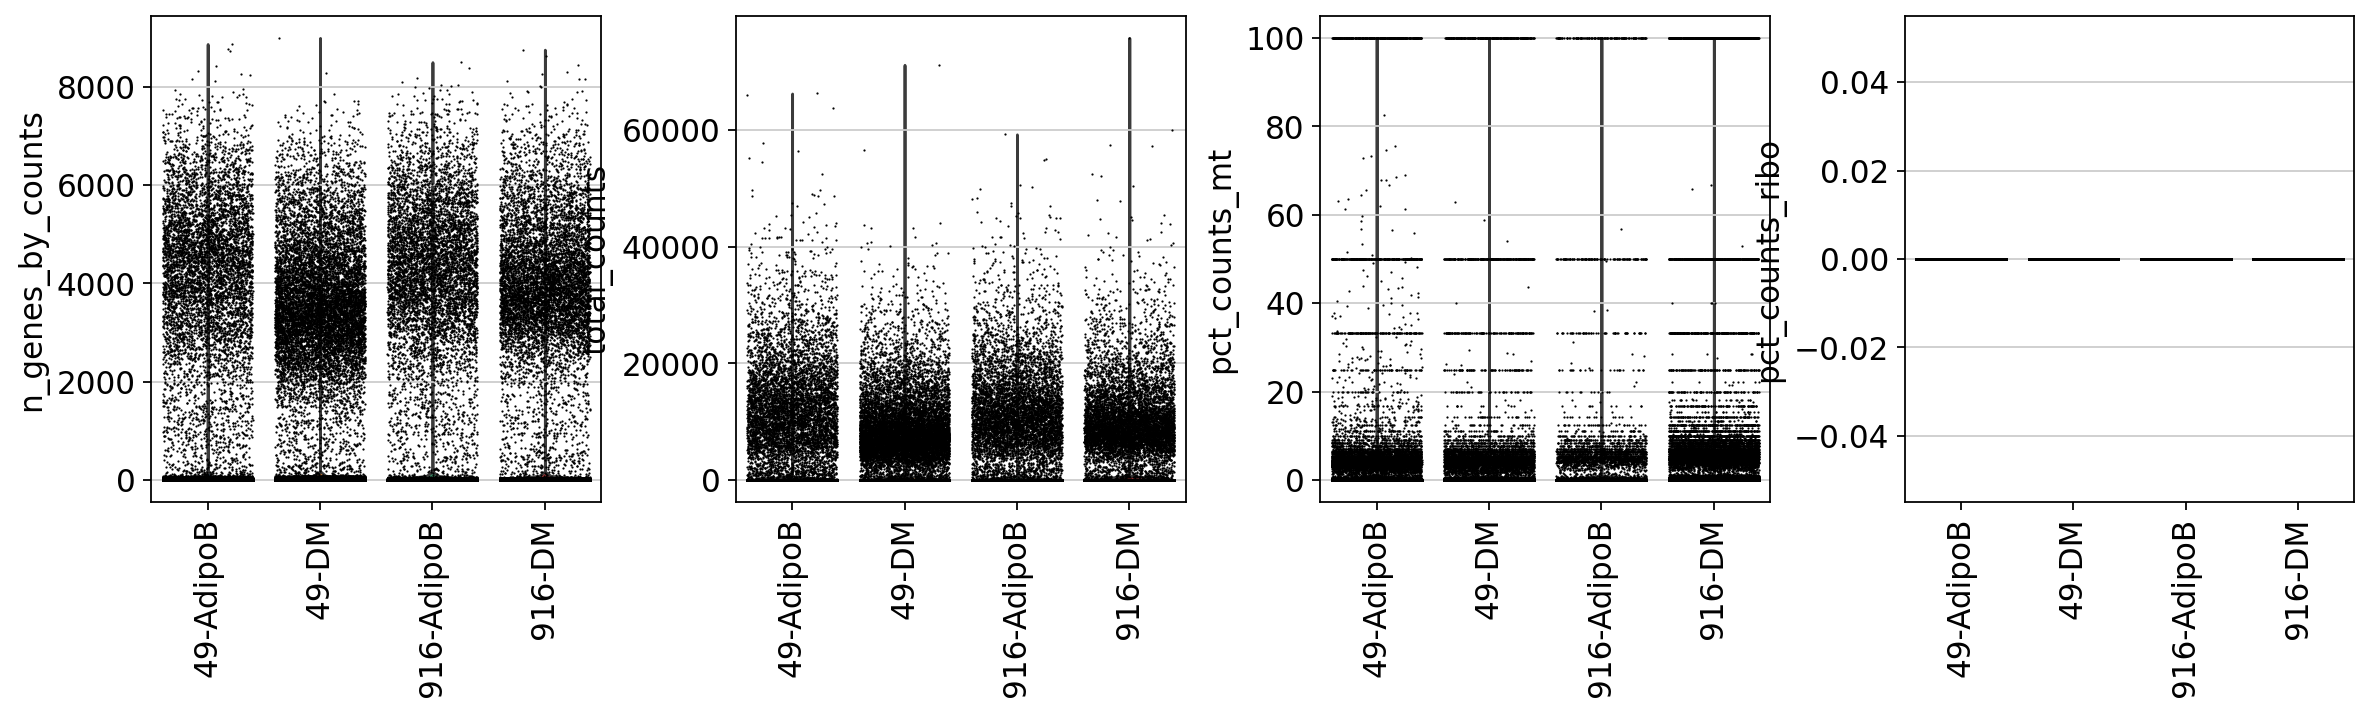

In [6]:
sc.pl.violin(adata,
             ['n_genes_by_counts',
              'total_counts',
              'pct_counts_mt',
              'pct_counts_ribo'],
             jitter = 0.4,
             groupby = 'cell_type',
             rotation=90,
             save = 'cell_type.png')

Total number of cells: 1717953
Number of cells after min count filter: 19452
Number of cells after MT filter: 19348
Number of cells after gene filter: 19342
Total number of genes: 37143
Number of genes after cell filter: 13850


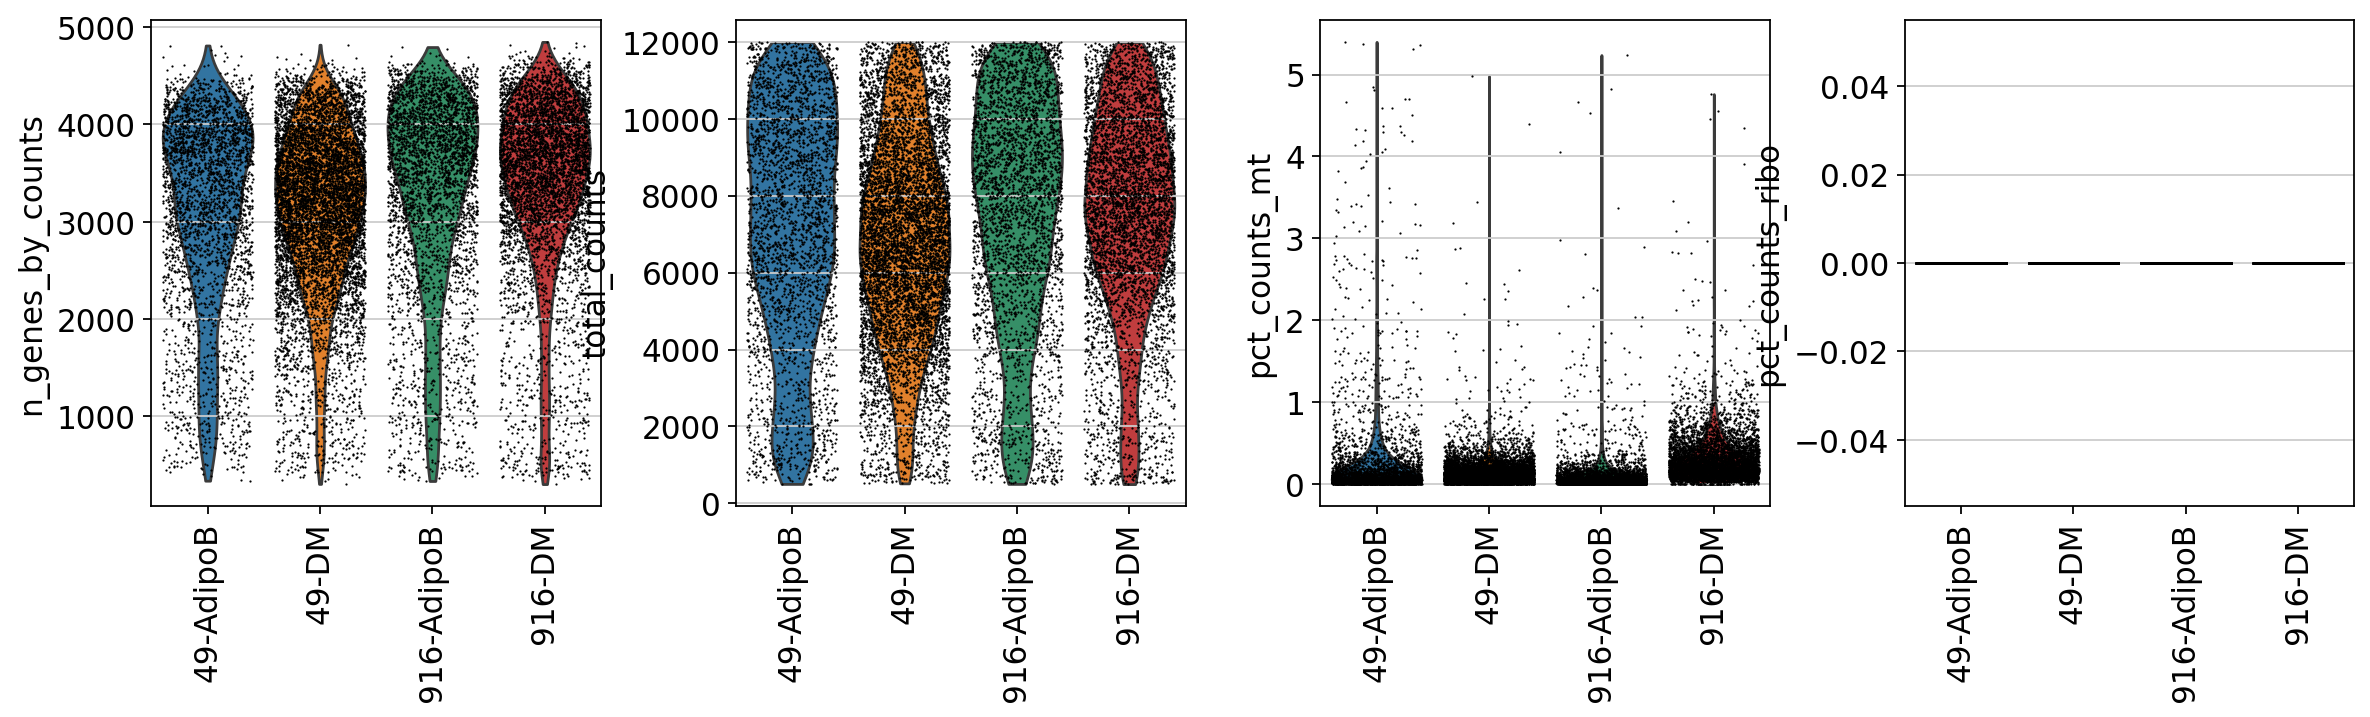

In [7]:
adata_store = adata

min_genes = 300
max_genes = 6000
min_counts= 500
max_counts = 12000
min_cells = 20


max_mt_ratio = 5.5


print(f'Total number of cells: {adata.n_obs:d}')

sc.pp.filter_cells(adata, min_counts = min_counts)
sc.pp.filter_cells(adata, max_counts = max_counts)
print(f'Number of cells after min count filter: {adata.n_obs:d}')

adata = adata[adata.obs.pct_counts_mt < max_mt_ratio]
print(f'Number of cells after MT filter: {adata.n_obs:d}')

sc.pp.filter_cells(adata, min_genes = min_genes)
sc.pp.filter_cells(adata, max_genes = max_genes)
print(f'Number of cells after gene filter: {adata.n_obs:d}')

print(f'Total number of genes: {adata.n_vars:d}')

sc.pp.filter_genes(adata, min_cells = min_cells)
print(f'Number of genes after cell filter: {adata.n_vars:d}')


sc.pl.violin(adata,
             ['n_genes_by_counts',
              'total_counts',
              'pct_counts_mt',
              'pct_counts_ribo'],
             jitter = 0.4,
             groupby = 'cell_type',
             rotation=90,
             save = 'cell_type.png')

In [8]:
sc.pp.scrublet(adata, batch_key="cell_type")

In [12]:
sc.pp.pca(adata)

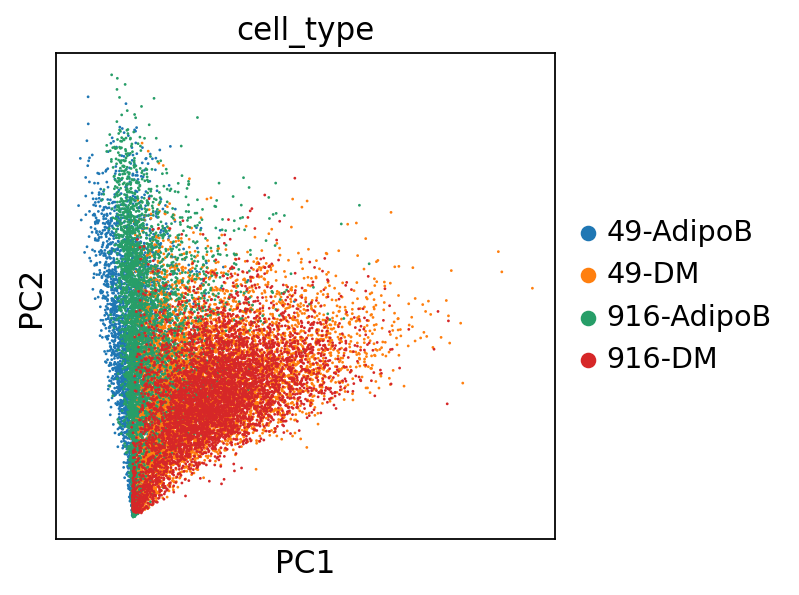

In [17]:
sc.pl.pca(adata, color="cell_type")

AttributeError: PolyCollection.set() got an unexpected keyword argument 'title'

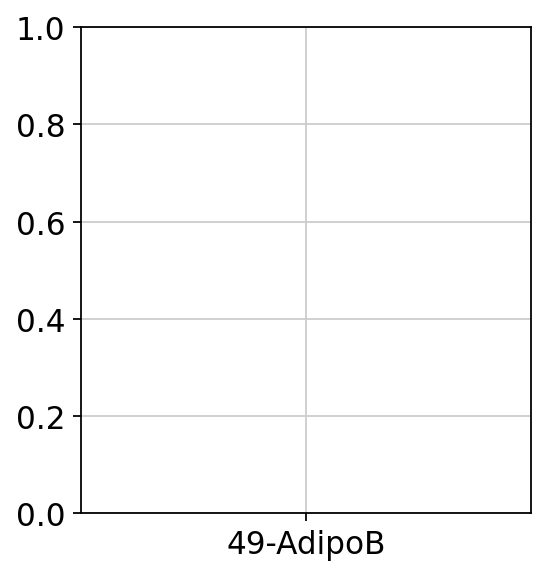

In [46]:
sc.pl.violin(adata, 'doublet_score',
             jitter = 0.4,
             groupby = 'cell_type',
             rotation=90,
             title = 'Doublet Score',
             save = '.doublet.png')

In [49]:
cell_types = adata.obs.cell_type.unique()

for cell_type in cell_types:
    cell_data = adata[adata.obs.cell_type == cell_type]
    ax = sc.pl.highest_expr_genes(cell_data, n_top=25, show=False)
    ax.set_title(f"{cell_type}", pad=20, size=14)
    ax.figure.savefig(f"figures/gene_counts_{cell_type}.png", dpi=80, bbox_inches='tight')
    plt.close()

/home/wlodychak.s/micromamba/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wlodychak.s/micromamba/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wlodychak.s/micromamba/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wlodychak.s/micromamba/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
